In [1]:
# Generic imports:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import math, random, re
import time
import pickle
from Bio import SeqIO
import multiprocessing
import glob
import os

In [44]:
# Machine learning/Stats imports:
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras import regularizers
from keras import optimizers
from keras.layers import Input, Dense, Lambda, Dropout, Activation, Bidirectional, RepeatVector, Reshape, LSTM
from keras import backend as K
from keras.engine.topology import Layer
from keras import objectives
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras import regularizers

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

In [3]:
class OnehotEmbedding2D(Layer):
    '''
    This is an alternative to the normal keras embedding layer
    which works on categorical data. This provides the same functionality
    but on a onehot encoding of the categorical data.
    '''
    def __init__(self, Nembeddings, **kwargs):
        self.Nembeddings = Nembeddings
        super(OnehotEmbedding2D, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[2], self.Nembeddings),
                                      initializer='uniform',
                                      trainable=True)
        super(OnehotEmbedding2D, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.Nembeddings)


In [4]:
# Amino acid alphabet:
AA_ORDER = 'ACDEFGHIKLMNPQRSTVWY-'
AA_LIST = list(AA_ORDER)
AA_DICT = {c:i for i, c in enumerate(AA_LIST)}
AA_DICT_REV = {i:c for i, c in enumerate(AA_LIST)}
AA_SET = set(AA_LIST)

# V genes:
V_GENE_LIST = ['TCRBV01-01', 'TCRBV02-01', 'TCRBV03-01', 'TCRBV03-02', 'TCRBV04-01', 'TCRBV04-02', 'TCRBV04-03',
               'TCRBV05-01', 'TCRBV05-02', 'TCRBV05-03', 'TCRBV05-04', 'TCRBV05-05', 'TCRBV05-06', 'TCRBV05-07',
               'TCRBV05-08', 'TCRBV06-01', 'TCRBV06-04', 'TCRBV06-05', 'TCRBV06-06', 'TCRBV06-07', 'TCRBV06-08',
               'TCRBV06-09', 'TCRBV07-01', 'TCRBV07-02', 'TCRBV07-03', 'TCRBV07-04', 'TCRBV07-05', 'TCRBV07-06',
               'TCRBV07-07', 'TCRBV07-08', 'TCRBV07-09', 'TCRBV08-02', 'TCRBV09-01', 'TCRBV10-01', 'TCRBV10-02',
               'TCRBV10-03', 'TCRBV11-01', 'TCRBV11-02', 'TCRBV11-03', 'TCRBV12-01', 'TCRBV12-02', 'TCRBV12-05',
               'TCRBV13-01', 'TCRBV14-01', 'TCRBV15-01', 'TCRBV16-01', 'TCRBV18-01', 'TCRBV19-01', 'TCRBV20-01',
               'TCRBV21-01', 'TCRBV22-01', 'TCRBV23-01', 'TCRBV23-or09_02', 'TCRBV25-01', 'TCRBV27-01', 'TCRBV28-01',
               'TCRBV29-01', 'TCRBV30-01', 'TCRBVA-or09_02']
V_GENE_DICT = {c:i for i, c in enumerate(V_GENE_LIST)}
V_GENE_DICT_REV = {i:c for i, c in enumerate(V_GENE_LIST)}
V_GENE_SET = set(V_GENE_LIST)

# J genes:
J_GENE_LIST = ['TCRBJ01-01', 'TCRBJ01-02', 'TCRBJ01-03', 'TCRBJ01-04', 'TCRBJ01-05', 'TCRBJ01-06', 'TCRBJ02-01',
               'TCRBJ02-02', 'TCRBJ02-03', 'TCRBJ02-04', 'TCRBJ02-05', 'TCRBJ02-06', 'TCRBJ02-07']
J_GENE_DICT = {c:i for i, c in enumerate(J_GENE_LIST)}
J_GENE_DICT_REV = {i:c for i, c in enumerate(J_GENE_LIST)}
J_GENE_SET = set(J_GENE_LIST)

In [5]:
try:
    import jellyfish
    def hamming_distance(s1, s2):
        if s1 == s2:
            return 0
        else:
            return jellyfish.hamming_distance(s1, s2)
except:
    def hamming_distance(seq1, seq2):
        '''Hamming distance between two sequences of equal length'''
        return sum(x != y for x, y in zip(seq1, seq2))

In [6]:
def TCRbeta2onehot(TCRB_list):
    '''
    Translate a list of TCR betas into onehot encodings.
    NB. all CDR3 sequences must be of equal length.
    '''
    seqlen = len(TCRB_list[0][0])
    assert(not [True for s in TCRB_list if len(s[0]) != seqlen])
    onehot_seq = np.zeros((len(TCRB_list), seqlen, len(AA_SET)))
    onehot_vgene = np.zeros((len(TCRB_list), len(V_GENE_SET)))
    onehot_jgene = np.zeros((len(TCRB_list), len(J_GENE_SET)))
    for i, el in enumerate(TCRB_list):
        seq, vgene, jgene = el
        onehot_vgene[i][V_GENE_DICT[vgene]] = 1
        onehot_jgene[i][J_GENE_DICT[jgene]] = 1
        for j, a in enumerate(seq):
            onehot_seq[i][j][AA_DICT[a]] = 1
    return(onehot_seq, onehot_vgene, onehot_jgene)

In [7]:
def onehot2TCRbeta(onehot_seq, onehot_vgene, onehot_jgene):
    '''
    Convert back from onehot encodings to TCR betas.
    '''
    TCRB_list = list()
    for i in range(onehot_seq.shape[0]):
        seq = list()
        for j in range(onehot_seq.shape[1]):
            seq.append(AA_DICT_REV[onehot_seq[i][j].argmax()])
        seq = ''.join(seq)
        vgene = V_GENE_DICT_REV[onehot_vgene[i].argmax()]
        jgene = J_GENE_DICT_REV[onehot_jgene[i].argmax()]
        TCRB_list.append((seq, vgene, jgene))
    return(TCRB_list)

In [27]:
# Read in some sequences:
MAX_SEQS = 10000000
MAX_LEN = 30
# fnam = '02-0249_TCRB_KD_cut.tsv'
fnam = 'all_TCRB_KD_cut.tsv'
TCRB_list = list()
for i, line in enumerate(open(fnam, 'r')):
    if i >= MAX_SEQS:
        break
    rows = line.strip().split()
    seq = str(rows[1])
    if len(seq) > MAX_LEN:
        continue
    else:  # Pad the middle with gaps
        pad_start = len(seq) // 2
        N_pad = MAX_LEN - len(seq)
        seq = seq[ :pad_start] + '-' * N_pad + seq[pad_start: ]
        assert(len(seq) == MAX_LEN)
        TCRB_list.append((seq, rows[2], rows[3]))

print('Input data has {} sequences.'.format(len(TCRB_list)))
print('This is how a typical TCR beta looks:\n{}'.format(TCRB_list[0]))

Input data has 1215734 sequences.
This is how a typical TCR beta looks:
('CAAAA--------------------AEAFF', 'TCRBV30-01', 'TCRBJ01-01')


In [28]:
# Transform to onehot:
onehot_CDR3, onehot_Vgene, onehot_Jgene = TCRbeta2onehot(TCRB_list)

In [11]:
# Various network definitions:
batch_size = 100
input_shape = [inp.shape[1:] for inp in (onehot_CDR3, onehot_Vgene, onehot_Jgene)]
input_total_dim = sum([np.array(shape).prod() for shape in input_shape])

embedding_output_dim = [10, 10, 5]
# embedding_output_dim = [21, 59, 13]  # Equal to no embedding
latent_dim = 20
dense_nodes = 100

epsilon_std = 1.0
def sampling(args):
    '''This function draws a sample from the multinomial defined by the latent variables.'''
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return(z_mean + K.exp(z_log_var / 2) * epsilon)

def vae_loss(io_encoder, io_decoder):
    '''The loss function is the sum of the cross-entropy and KL divergence.'''
    # Notice that "objectives.categorical_crossentropy(io_encoder, io_decoder)"
    # is a vector so it is averaged using "K.mean":
    xent_loss = io_decoder.shape.num_elements() * K.mean(objectives.categorical_crossentropy(io_encoder, io_decoder))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    kl_loss *= 1 / 3 * batch_size # Because we have three input/output
    return(xent_loss + kl_loss)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
onehot_CDR3 (InputLayer)         (None, 30, 21)        0                                            
____________________________________________________________________________________________________
CDR3_embedding (OnehotEmbedding2 (None, 30, 10)        210         onehot_CDR3[0][0]                
____________________________________________________________________________________________________
onehot_Vgene (InputLayer)        (None, 59)            0                                            
____________________________________________________________________________________________________
onehot_Jgene (InputLayer)        (None, 13)            0                                            
___________________________________________________________________________________________

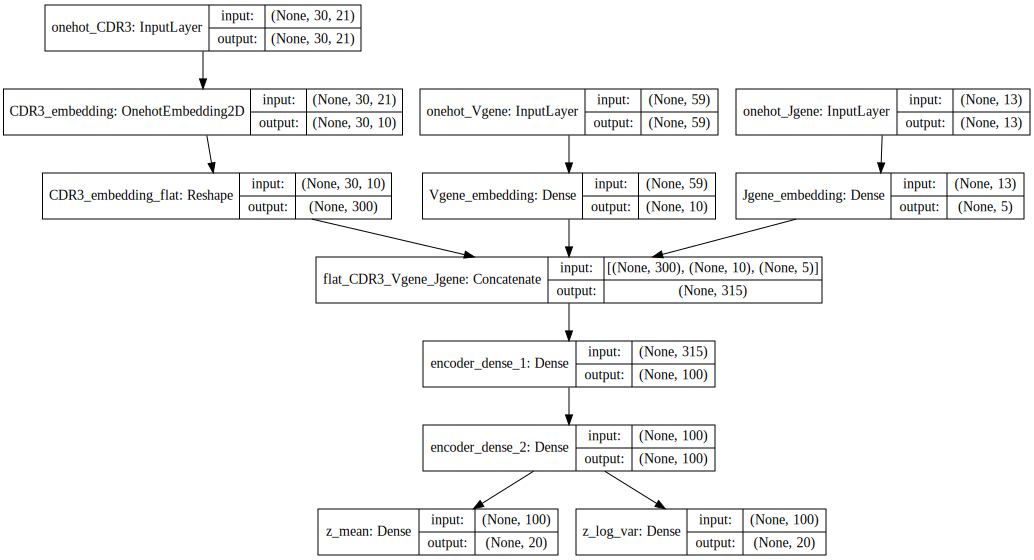

In [12]:
# Encoding layers:
encoder_input_CDR3 = Input(shape=input_shape[0], name='onehot_CDR3')
encoder_input_Vgene = Input(shape=input_shape[1], name='onehot_Vgene')
encoder_input_Jgene = Input(shape=input_shape[2], name='onehot_Jgene')

embedding_CDR3 = OnehotEmbedding2D(embedding_output_dim[0], name='CDR3_embedding')(encoder_input_CDR3)
embedding_CDR3_flat = Reshape([embedding_output_dim[0] * MAX_LEN], name='CDR3_embedding_flat')(embedding_CDR3)
embedding_Vgene = Dense(embedding_output_dim[1], name='Vgene_embedding')(encoder_input_Vgene)
Vgene_embedding = Model(encoder_input_Vgene, embedding_Vgene)
embedding_Jgene = Dense(embedding_output_dim[2], name='Jgene_embedding')(encoder_input_Jgene)
Jgene_embedding = Model(encoder_input_Jgene, embedding_Jgene)


merged_input = keras.layers.concatenate([embedding_CDR3_flat, embedding_Vgene, embedding_Jgene], name='flat_CDR3_Vgene_Jgene')
dense_encoder1 = Dense(dense_nodes, activation='elu', name='encoder_dense_1')(merged_input)
dense_encoder2 = Dense(dense_nodes, activation='elu', name='encoder_dense_2')(dense_encoder1)

# Latent layers:
z_mean = Dense(latent_dim, name='z_mean')(dense_encoder2)
z_log_var = Dense(latent_dim, name='z_log_var')(dense_encoder2)

encoder = Model([encoder_input_CDR3, encoder_input_Vgene, encoder_input_Jgene], [z_mean, z_log_var])
encoder.summary()
# plot_model(encoder, to_file='encoder.svg', show_shapes=True)
SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 20)            0                                            
____________________________________________________________________________________________________
decoder_dense_1 (Dense)          (None, 100)           2100        input_1[0][0]                    
                                                                   input_1[0][0]                    
                                                                   input_1[0][0]                    
____________________________________________________________________________________________________
decoder_dense_2 (Dense)          (None, 100)           10100       decoder_dense_1[3][0]            
                                                                   decoder_dense_1[4][0]   

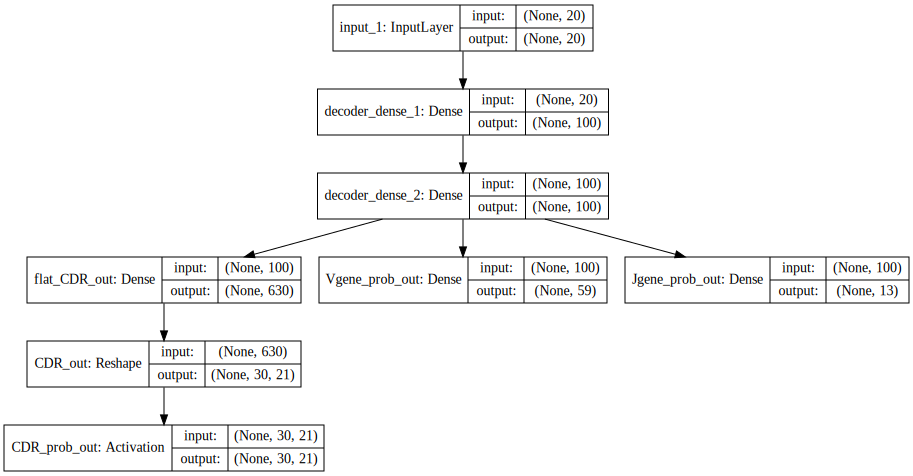

In [13]:
# Decoding layers:
z = Lambda(sampling, output_shape=(latent_dim, ), name='reparameterization_trick')  # This is the reparameterization trick
dense_decoder1 = Dense(dense_nodes, activation='elu', name='decoder_dense_1')
dense_decoder2 = Dense(dense_nodes, activation='elu', name='decoder_dense_2')

decoder_out_CDR3 = Dense(np.array(input_shape[0]).prod(), activation='linear', name='flat_CDR_out')
reshape_CDR3 = Reshape(input_shape[0], name='CDR_out')
position_wise_softmax_CDR3 = Activation(activation='softmax', name='CDR_prob_out')
decoder_out_Vgene = Dense(input_shape[1][0], activation='softmax', name='Vgene_prob_out')
decoder_out_Jgene = Dense(input_shape[2][0], activation='softmax', name='Jgene_prob_out')

decoder_output_CDR3 = position_wise_softmax_CDR3(reshape_CDR3(decoder_out_CDR3(dense_decoder2(dense_decoder1(z([z_mean, z_log_var]))))))
decoder_output_Vgene = decoder_out_Vgene(dense_decoder2(dense_decoder1(z([z_mean, z_log_var]))))
decoder_output_Jgene = decoder_out_Jgene(dense_decoder2(dense_decoder1(z([z_mean, z_log_var]))))

# Define the decoding part separately:
z_mean_generator = Input(shape=(latent_dim,))
decoder_generator_CDR3 = position_wise_softmax_CDR3(reshape_CDR3(decoder_out_CDR3(dense_decoder2(dense_decoder1(z_mean_generator)))))
decoder_generator_Vgene = decoder_out_Vgene(dense_decoder2(dense_decoder1(z_mean_generator)))
decoder_generator_Jgene = decoder_out_Jgene(dense_decoder2(dense_decoder1(z_mean_generator)))

decoder = Model(z_mean_generator, [decoder_generator_CDR3, decoder_generator_Vgene, decoder_generator_Jgene])
decoder.summary()
# plot_model(decoder, to_file='decoder.svg', show_shapes=True)
SVG(model_to_dot(decoder, show_shapes=True).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
onehot_CDR3 (InputLayer)         (None, 30, 21)        0                                            
____________________________________________________________________________________________________
CDR3_embedding (OnehotEmbedding2 (None, 30, 10)        210         onehot_CDR3[0][0]                
____________________________________________________________________________________________________
onehot_Vgene (InputLayer)        (None, 59)            0                                            
____________________________________________________________________________________________________
onehot_Jgene (InputLayer)        (None, 13)            0                                            
___________________________________________________________________________________________

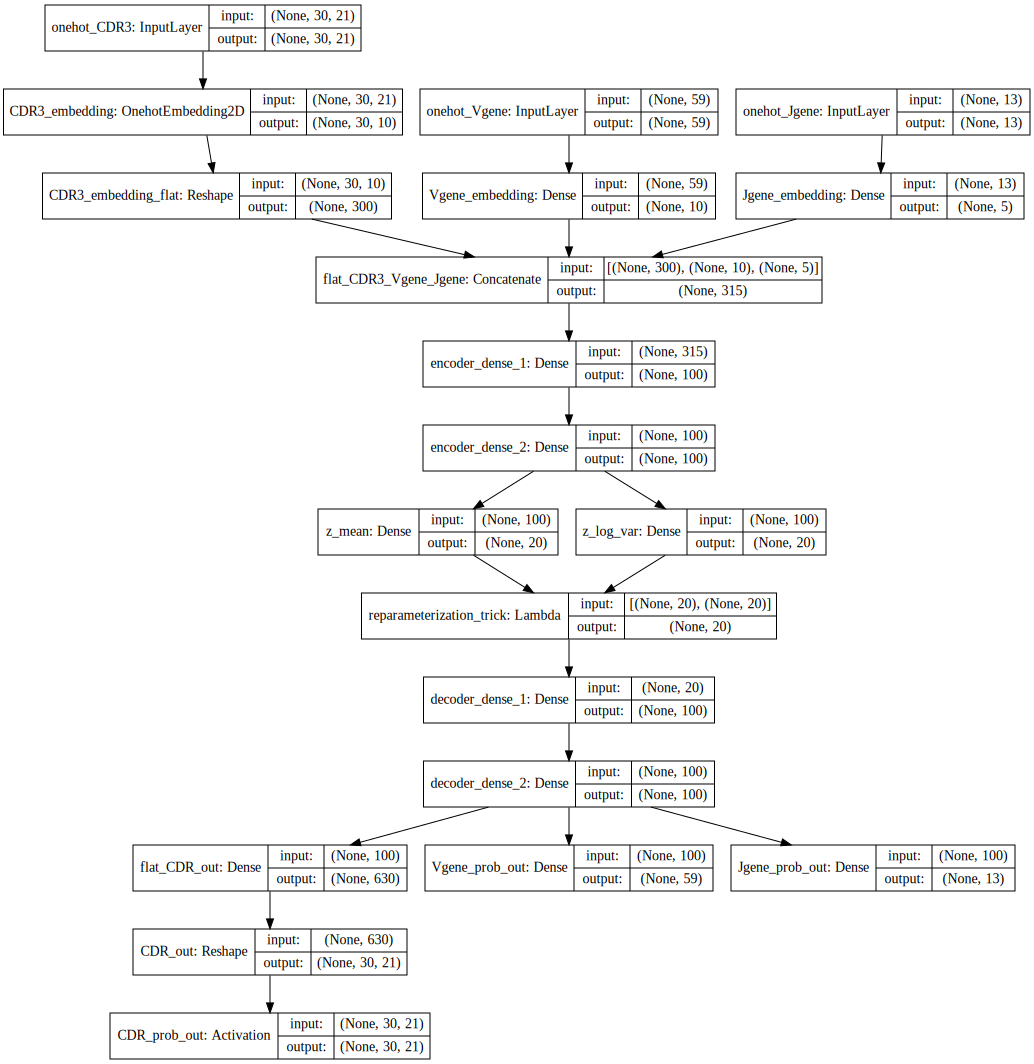

In [14]:
vae = Model([encoder_input_CDR3, encoder_input_Vgene, encoder_input_Jgene], [decoder_output_CDR3, decoder_output_Vgene, decoder_output_Jgene])
vae.compile(optimizer="adam", loss=vae_loss)
vae.summary()
#vae.save('two_layer_vae_TCR_init.h5')
plot_model(vae, to_file='vae_TCR.svg', show_shapes=True)
SVG(model_to_dot(vae, show_shapes=True).create(prog='dot', format='svg'))

In [29]:
# Shuffle the data:
perm_idxs = np.random.permutation(onehot_CDR3.shape[0])
onehot_CDR3 = np.take(onehot_CDR3, perm_idxs, axis=0)
onehot_Vgene = np.take(onehot_Vgene, perm_idxs, axis=0)
onehot_Jgene = np.take(onehot_Jgene, perm_idxs, axis=0)

# Split dataset into train/test:
sl = len(onehot_CDR3) // (batch_size*100)
onehot_CDR3 = onehot_CDR3[:(sl*batch_size*100)]
onehot_Vgene = onehot_Vgene[:(sl*batch_size*100)]
onehot_Jgene = onehot_Jgene[:(sl*batch_size*100)]

In [30]:
test_fraction = 0.1
test_size = int(test_fraction * len(onehot_CDR3))
train_size = len(onehot_CDR3) - test_size
train_mask = np.array([True]*train_size + [False]*test_size)
np.random.shuffle(train_mask)
test_mask = train_mask == False
assert(sum(train_mask*test_mask) == 0)

In [35]:
x_train_CDR3 = onehot_CDR3[train_mask]
x_test_CDR3 = onehot_CDR3[test_mask]
x_train_Vgene = onehot_Vgene[train_mask]
x_test_Vgene = onehot_Vgene[test_mask]
x_train_Jgene = onehot_Jgene[train_mask]
x_test_Jgene = onehot_Jgene[test_mask]

In [ ]:
nb_epoch = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
best_weights_filename = "two_layer_dense_vae-TCR_weights.best.hdf5"
save_best_weights = ModelCheckpoint(best_weights_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
vae_log = vae.fit([x_train_CDR3, x_train_Vgene, x_train_Jgene],
                  [x_train_CDR3, x_train_Vgene, x_train_Jgene],  # VAE is unsupervised so y=X
                  shuffle=True,
                  epochs=nb_epoch,
                  batch_size=batch_size,
                  validation_split=0.1,
                  callbacks=[early_stopping, save_best_weights])
vae.load_weights(best_weights_filename)  # Load best weights after early stopping kicks in

Train on 980100 samples, validate on 108900 samples
Epoch 1/100
980100/980100 [==============================] - 180s - loss: 6251.2469 - CDR_prob_out_loss: 3413.4225 - Vgene_prob_out_loss: 1432.4598 - Jgene_prob_out_loss: 1405.3646 - val_loss: 6194.2557 - val_CDR_prob_out_loss: 3400.8537 - val_Vgene_prob_out_loss: 1401.5686 - val_Jgene_prob_out_loss: 1391.8334
Epoch 2/100
980100/980100 [==============================] - 182s - loss: 6054.6848 - CDR_prob_out_loss: 3248.2991 - Vgene_prob_out_loss: 1416.9047 - Jgene_prob_out_loss: 1389.4810 - val_loss: 5971.9622 - val_CDR_prob_out_loss: 3204.6429 - val_Vgene_prob_out_loss: 1386.2897 - val_Jgene_prob_out_loss: 1381.0296
Epoch 3/100
980100/980100 [==============================] - 178s - loss: 5899.9620 - CDR_prob_out_loss: 3120.0248 - Vgene_prob_out_loss: 1402.9358 - Jgene_prob_out_loss: 1377.0014 - val_loss: 5996.5608 - val_CDR_prob_out_loss: 3146.6685 - val_Vgene_prob_out_loss: 1456.0689 - val_Jgene_prob_out_loss: 1393.8234
Epoch 4/100


In [15]:
# Save/load trained weights:
#vae.save('two_layer_vae.h5')
#vae.load_weights('two_layer_vae.h5')

In [47]:
# Let's look at the loss on the train vs. the hold out test set:
trainset_loss = vae.evaluate(x=[x_train_CDR3, x_train_Vgene, x_train_Jgene], y=[x_train_CDR3, x_train_Vgene, x_train_Jgene], batch_size=batch_size)
testset_loss = vae.evaluate(x=[x_test_CDR3, x_test_Vgene, x_test_Jgene], y=[x_test_CDR3, x_test_Vgene, x_test_Jgene], batch_size=batch_size)
print('Component-wise loss Train vs. Test:')
for i in [1, 2, 3]:
    print('{}: {.2f} vs. {.2f}'.format(vae.metrics_names[i], trainset_loss[i], testset_loss[i]))
print('# Sum of losses #\nTrain set: {.2f}\nTest set: {.2f}'.format(trainset_loss[0], testset_loss[0]))

 99200/100000 [============================>.] - ETA: 0s

[10126.683692871095, 6963.187038574219, 1641.6643145751952, 1521.832328491211]

In [292]:
# Encode a chunk of testset data into latent space:
chunk = 10000
x_test_encoded = encoder.predict([x_test_CDR3[0:chunk], x_test_Vgene[0:chunk], x_test_Jgene[0:chunk]])
print('Output shape: [{}, {}]'.format(x_test_encoded[0].shape, x_test_encoded[0].shape))

Output shape: [(10000, 20), (10000, 20)]


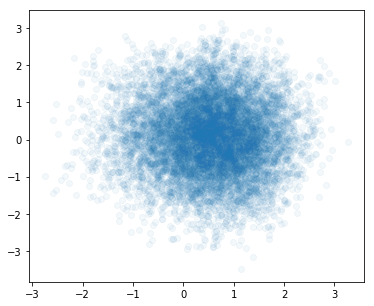

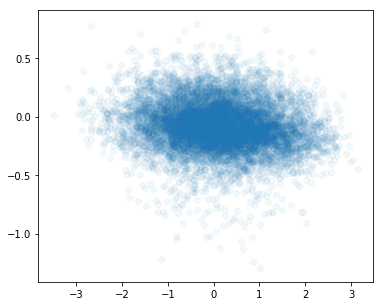

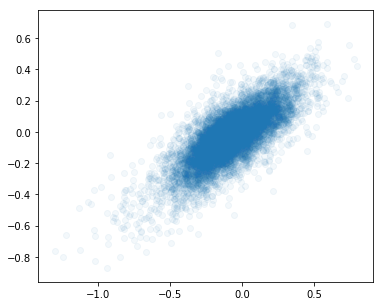

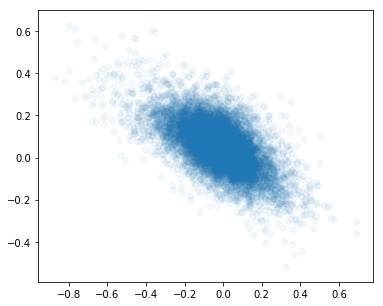

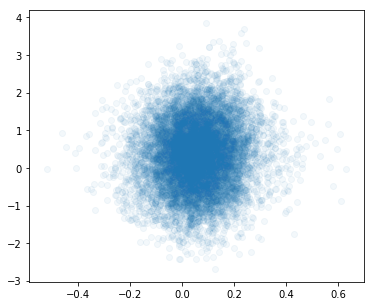

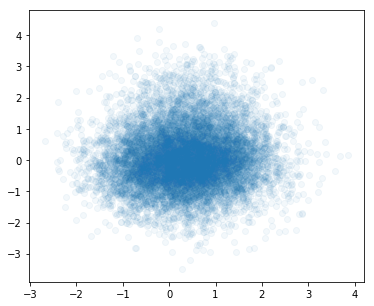

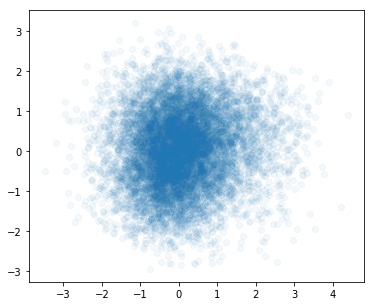

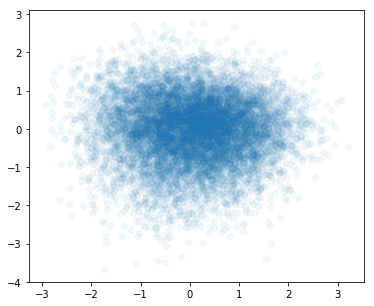

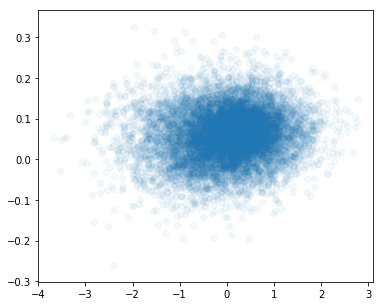

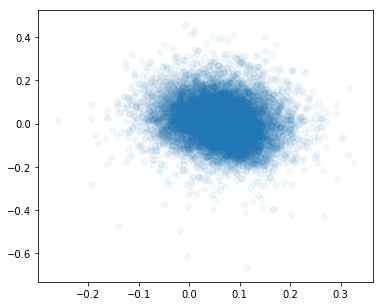

In [231]:
# Take a quick look at the latent space:
for i in range(10):
    x = list(x_test_encoded[0][:, i])
    y = list(x_test_encoded[0][:, i+1])
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, alpha=0.05);

In [232]:
# Do a PCA to see how much explained variance that can be extracted
# from any two dimensional combination of the latent space:
pca = PCA(n_components=2)
pca.fit(x_test_encoded[0])
print('PCA total explained variance in two dimensions is {:.3}%'.format(pca.explained_variance_ratio_.sum() * 100))

PCA total explained variance in two dimensions is 15.3%


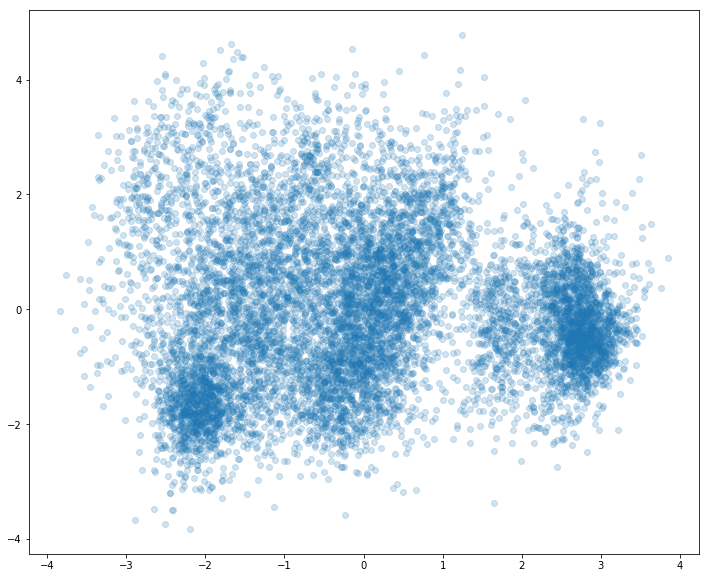

In [233]:
# Plot the PCA results:
X_r = pca.fit(x_test_encoded[0]).transform(x_test_encoded[0])
plt.figure(figsize=(12, 10))
x = list(X_r[:,0])
y = list(X_r[:, 1])
plt.scatter(x, y, alpha=0.2);

In [235]:
# Decode the chunk of testdata from latent space into the original input space:
x_test_CDR3_decoded, x_test_Vgene_decoded, x_test_Jgene_decoded = decoder.predict(x_test_encoded[0])

In [236]:
# The softmax activation on the last layer should bound the sum of each position to 1.
# This enable us to intepret the values as probabilities.
print('The sum of character probabilities at position one is: {}'.format(str(sum(x_test_CDR3_decoded[0][0]))))
print('The sum of probabilities at all {} positions is: {}'.format(str(x_test_CDR3_decoded.shape[1]), str(sum(sum(x_test_CDR3_decoded[0])))))

The sum of character probabilities at position one is: 1.0000000000296838
The sum of probabilities at all 30 positions is: 29.999999778348677


In [238]:
# Then translate the onehot encoding to a sequence:
TCRb_test = onehot2TCRbeta(x_test_CDR3[0:chunk], x_test_Vgene[0:chunk], x_test_Jgene[0:chunk])
TCRb_test_decoded = onehot2TCRbeta(x_test_CDR3_decoded, x_test_Vgene_decoded, x_test_Jgene_decoded)

In [255]:
# Compare the input sequences with those that have been a roundtrip through the VAE:
mismatches = 0
print('First line is the input sequence.\nSecond line is the VAE output.\nThird line is the amino acid identity for the input sequence in case of disagreements.\nFourth line is the amino acid identity for the VAE output in case of disagreements.\n')
for i in range(100):
    y = list(TCRb_test[i][0]) + [' ']*5 + [TCRb_test[i][1]] + [' ']*5 + [TCRb_test[i][2]]
    p = list(TCRb_test_decoded[i][0]) + [' ']*5 + [TCRb_test_decoded[i][1]] + [' ']*5 + [TCRb_test_decoded[i][2]]
    print(''.join(y))
    print(''.join(p))
    print('{}'.format(''.join([' ' if i==j else '*'*len(i) for i,j in zip(y, p)])))
    print()
    mismatches += sum(0 if i==j else 1 for i,j in zip(y, p))
print('\nTotal disagreements: {}'.format(mismatches))

First line is the input sequence.
Second line is the VAE output.
Third line is the amino acid identity for the input sequence in case of disagreements.
Fourth line is the amino acid identity for the VAE output in case of disagreements.

CAAAEVR----------------GNTEAFF     TCRBV02-01     TCRBJ01-01
CAAAEVR----------------GNTEAFF     TCRBV02-01     TCRBJ01-01
                                          

CAAAGG-----------------PGNEQFF     TCRBV19-01     TCRBJ02-01
CAAAGG-----------------PGNEQFF     TCRBV19-01     TCRBJ02-01
                                          

CAAAGS------------------NQPQHF     TCRBV10-02     TCRBJ01-05
CAAAGS------------------NQPQHF     TCRBV10-02     TCRBJ01-05
                                          

CAAAHPAM-------------SGLAGELFF     TCRBV05-04     TCRBJ02-02
CASAHPAP-------------SGLAVELFF     TCRBV05-04     TCRBJ02-02
  *    *                 *                

CAAAIQ------------------SPEQYF     TCRBV06-01     TCRBJ02-07
CAAAIQ------------------SPEQYF     TCR

In [259]:
# Sample from the latent space to generate new TCR betas:
lsample = np.random.normal(0, 1, size=(batch_size * 100, latent_dim))
vae_sample_CDR3, vae_sample_Vgene, vae_sample_Jgene = decoder.predict(lsample)
vae_sample_TCRb = onehot2TCRbeta(vae_sample_CDR3, vae_sample_Vgene, vae_sample_Jgene)

In [260]:
for i in range(100):
    y = list(vae_sample_TCRb[i][0]) + [' ']*5 + [vae_sample_TCRb[i][1]] + [' ']*5 + [vae_sample_TCRb[i][2]]
    print(''.join(y))

CASSPG-----------------IGDGYTF     TCRBV25-01     TCRBJ01-02
CASIPGTG--------------GGHNGYTF     TCRBV10-02     TCRBJ01-02
CASSPERI--------------GISRGSFF     TCRBV04-01     TCRBJ02-01
CASSLQGT--------------HDNQPQHF     TCRBV27-01     TCRBJ01-05
CASSLHN----------------RVDTQYF     TCRBV28-01     TCRBJ02-05
CASSDFRR--------------QLNYEQYF     TCRBV23-01     TCRBJ02-07
CASSSSLV--------------ITAREAFF     TCRBV06-04     TCRBJ01-01
CASSSDGG--------------QGSQPQHF     TCRBV07-08     TCRBJ01-05
CASSQIEL--------------HHRETQYF     TCRBV16-01     TCRBJ02-05
CASTMAL----------------DEDEQYF     TCRBV10-01     TCRBJ02-07
CASSERV---------------QHESELFF     TCRBV06-01     TCRBJ01-06
CASIIGA-----------------DYEAYF     TCRBV06-05     TCRBJ02-04
CASSGGP---------------GHNNTQYF     TCRBV07-07     TCRBJ02-04
CASKNR------------------NQPQHF     TCRBV30-01     TCRBJ01-05
CASSLLG----------------GSDTYYF     TCRBV05-06     TCRBJ01-02
CASGRSPR--------------LIYNEQFF     TCRBV05-01     TCRBJ02-01
CASRWYN---------------GA

In [274]:
# Look at the embeddings
onehot_Vgenes = np.zeros((batch_size, len(V_GENE_SET)))
Vgene_labels = list()
for vgene, idx in V_GENE_DICT.items():
    Vgene_labels.append(vgene)
    onehot_Vgenes[idx][idx] = 1

In [271]:
Vgenes_embedded = Vgene_embedding.predict(onehot_Vgenes)
Vgenes_embedded = Vgenes_embedded[:len(V_GENE_SET)]

In [281]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=1).fit(Vgenes_embedded)
cmap = kmeans.labels_

In [286]:
sorted([(kl, vgene) for kl, vgene in zip(kmeans.labels_, Vgene_labels)], key=lambda x: x[0])

[(0, 'TCRBV06-04'),
 (0, 'TCRBV06-09'),
 (0, 'TCRBV07-01'),
 (0, 'TCRBV12-02'),
 (0, 'TCRBV23-or09_02'),
 (1, 'TCRBV05-05'),
 (1, 'TCRBV06-06'),
 (1, 'TCRBV07-08'),
 (1, 'TCRBV10-02'),
 (1, 'TCRBV11-02'),
 (1, 'TCRBV18-01'),
 (1, 'TCRBVA-or09_02'),
 (2, 'TCRBV05-04'),
 (2, 'TCRBV06-01'),
 (2, 'TCRBV07-06'),
 (2, 'TCRBV07-09'),
 (2, 'TCRBV10-01'),
 (2, 'TCRBV10-03'),
 (2, 'TCRBV13-01'),
 (2, 'TCRBV15-01'),
 (3, 'TCRBV03-01'),
 (3, 'TCRBV22-01'),
 (4, 'TCRBV04-01'),
 (4, 'TCRBV07-03'),
 (4, 'TCRBV09-01'),
 (4, 'TCRBV30-01'),
 (5, 'TCRBV01-01'),
 (5, 'TCRBV05-02'),
 (5, 'TCRBV05-03'),
 (5, 'TCRBV05-07'),
 (5, 'TCRBV06-07'),
 (5, 'TCRBV06-08'),
 (5, 'TCRBV07-05'),
 (5, 'TCRBV12-01'),
 (5, 'TCRBV16-01'),
 (5, 'TCRBV29-01'),
 (6, 'TCRBV05-06'),
 (6, 'TCRBV05-08'),
 (6, 'TCRBV07-02'),
 (6, 'TCRBV19-01'),
 (6, 'TCRBV20-01'),
 (6, 'TCRBV21-01'),
 (6, 'TCRBV25-01'),
 (6, 'TCRBV27-01'),
 (6, 'TCRBV28-01'),
 (7, 'TCRBV02-01'),
 (7, 'TCRBV04-02'),
 (7, 'TCRBV04-03'),
 (7, 'TCRBV05-01'),
 (7, 'TCRBV

In [ ]:
fig = plt.figure(figsize=(12,12))

In [ ]:
# Plot V gene clusters:
plt.figure(figsize=(12, 10))

plt.scatter(x_train_encoded[:, z1][::-1], x_train_encoded[:, z2][::-1], c=cmap[::-1] ,alpha=1, marker="o");


In [278]:
# Do a PCA:
pca = PCA(n_components=2)
pca.fit(Vgenes_embedded)
print('PCA total explained variance in two dimensions is {:.3}%'.format(pca.explained_variance_ratio_.sum() * 100))

PCA total explained variance in two dimensions is 31.7%


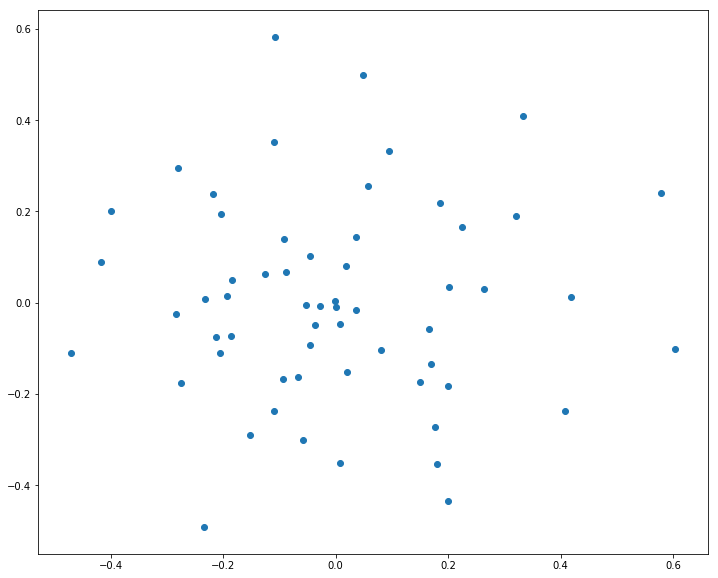

In [283]:
# Plot the PCA results:
X_r = pca.fit(Vgenes_embedded).transform(Vgenes_embedded)
plt.figure(figsize=(12, 10))
x = list(X_r[:,0])
y = list(X_r[:, 1])
plt.scatter(x, y, alpha=1);